### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import KMeansClusterMain, BaseLoader
import plotly.express as px
from funcs import to_float, get_density, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config

### Select the data

In [2]:
sql_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
df_stock = pd.read_sql(sql_query.format(symbol), create_engine(mariadb_string))
df_stock["date"] = pd.to_datetime(df_stock["date"])
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol ADS.DEX: Adidas
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol FNTN.DE: Freenet
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol NRDBY: Nordea Bank Abp ADR
symbol PAH3.DE: Porsche SE
symbol SBUX: Starbucks
symbol SY1.DE: Symrise
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  DASH


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  771 non-null    object        
 1   date    771 non-null    datetime64[ns]
 2   open    771 non-null    float64       
 3   high    771 non-null    float64       
 4   low     771 non-null    float64       
 5   close   771 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 36.3+ KB


### Get the Volatility

In [3]:
# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

In [4]:
df_stock.head()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
0,DASH,2022-07-01,65.05,69.330,65.05,67.95,NaN,NaN
1,DASH,2022-07-05,66.22,75.060,65.69,74.90,NaN,NaN
2,DASH,2022-07-06,67.79,70.000,66.84,69.36,NaN,NaN
3,DASH,2022-07-07,69.33,76.000,68.18,76.00,NaN,NaN
4,DASH,2022-07-08,74.20,77.415,72.56,74.96,NaN,NaN


In [5]:
df_stock.tail()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
766,DASH,2025-07-25,244.78,250.23,243.36,249.92,12.2,6.394762
767,DASH,2025-07-28,250.00,250.71,244.02,246.44,12.2,6.426190
768,DASH,2025-07-29,247.90,248.01,240.38,243.20,12.2,6.469524
769,DASH,2025-07-31,248.30,252.87,247.47,250.25,12.2,6.341762
770,DASH,2025-08-01,248.16,249.24,242.01,248.35,12.2,6.355095


### Check the chart

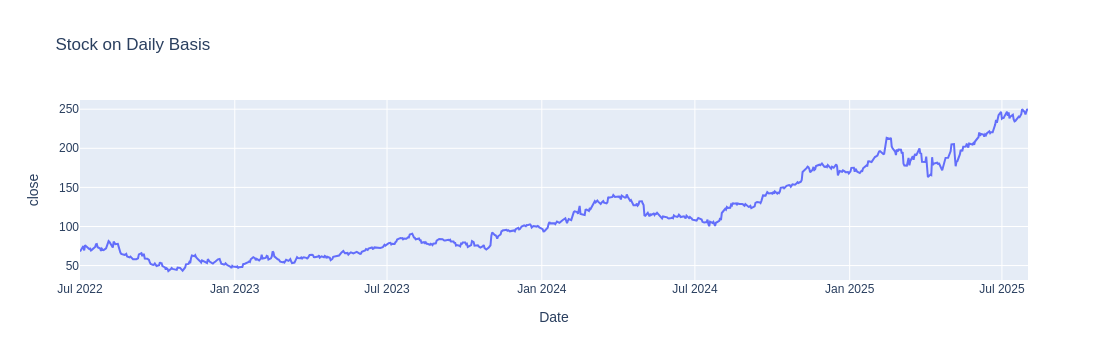

In [6]:
fig = px.line(df_stock, x="date", y="close", title="Stock on Daily Basis", 
              labels={"date": "Date"})

fig.show()

### The Mean Volatility

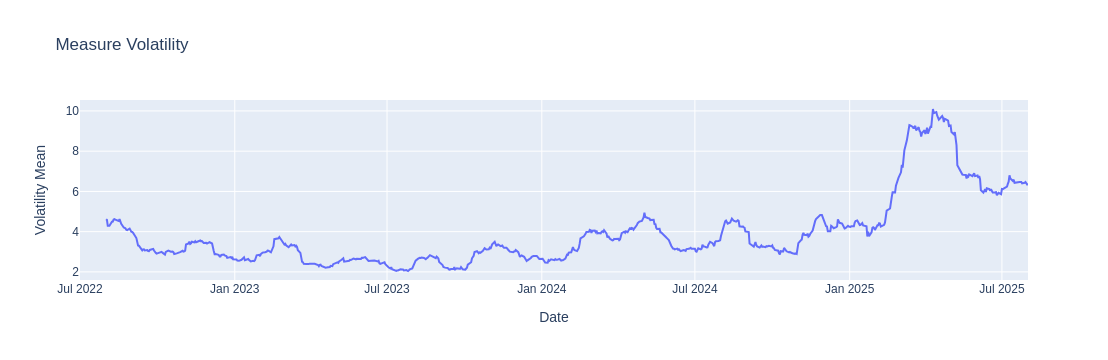

In [7]:
fig = px.line(df_stock, x="date", y="volatility_mean", title="Measure Volatility", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

### The Max Volatility

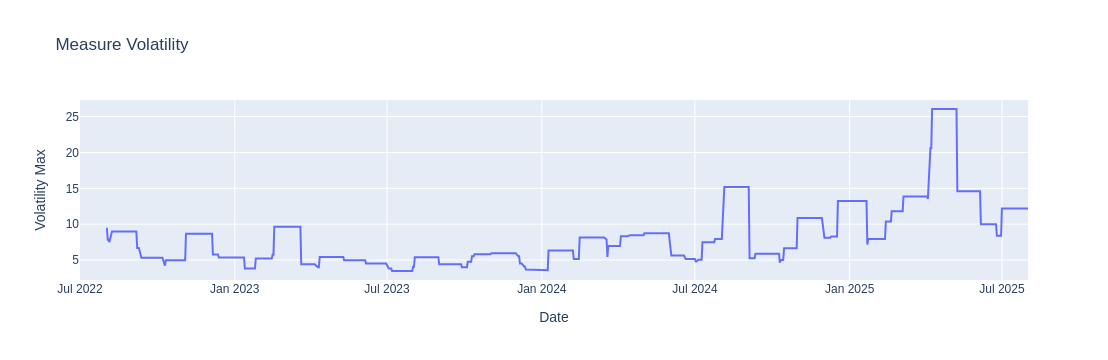

In [8]:
fig = px.line(df_stock, x="date", y="volatility_max", title="Measure Volatility",
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Compute the main process

1. Calculate the percentage change on daily bases

2. Within the percentage change datapoints calculate the clusters with the help of the KMeans-Clustering-Algorithm

3. Calculate the necessary density column with the cluster labels and sum up the kmeans centroids with that and save them

In [9]:
# Compute the percentage change
df_stock["perc_change"] = ((df_stock["open"] + df_stock["high"] + df_stock["low"] + df_stock["close"]) / 3).pct_change()
df_stock.dropna(inplace=True)
df_stock = df_stock[df_stock['perc_change'] != 0.0]

# Here comes KMeans
datapoints = df_stock["perc_change"].to_list()
kmeans = KMeansClusterMain(3)
kmeans.fit(datapoints) 

# Assign the clusters
df_stock["cluster"] = kmeans.labels
df_stock["cluster"] = pd.to_numeric(df_stock["cluster"])

# Get the density for the colormap
df_stock["density"] = df_stock["cluster"].rolling(21).apply(get_density, kwargs={'orig_density': kmeans.centroids})

# cluster_str needed for kmeans volatility cluster graph.
df_stock["cluster_str"] = df_stock.cluster.astype(str)
df_stock['perc_change'] = df_stock['perc_change'] * 100

print(df_stock.isna().any())
print(df_stock.info())

symbol             False
date               False
open               False
high               False
low                False
close              False
volatility_max     False
volatility_mean    False
perc_change        False
cluster            False
density             True
cluster_str        False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Index: 751 entries, 20 to 770
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           751 non-null    object        
 1   date             751 non-null    datetime64[ns]
 2   open             751 non-null    float64       
 3   high             751 non-null    float64       
 4   low              751 non-null    float64       
 5   close            751 non-null    float64       
 6   volatility_max   751 non-null    float64       
 7   volatility_mean  751 non-null    float64       
 8   perc_change      751 non-null    float64       
 9  

### Determine the boundaries of the density

count    731.000000
mean       0.037685
std        0.092255
min       -0.260623
25%       -0.021679
50%        0.048009
75%        0.116403
max        0.257505
Name: density, dtype: float64


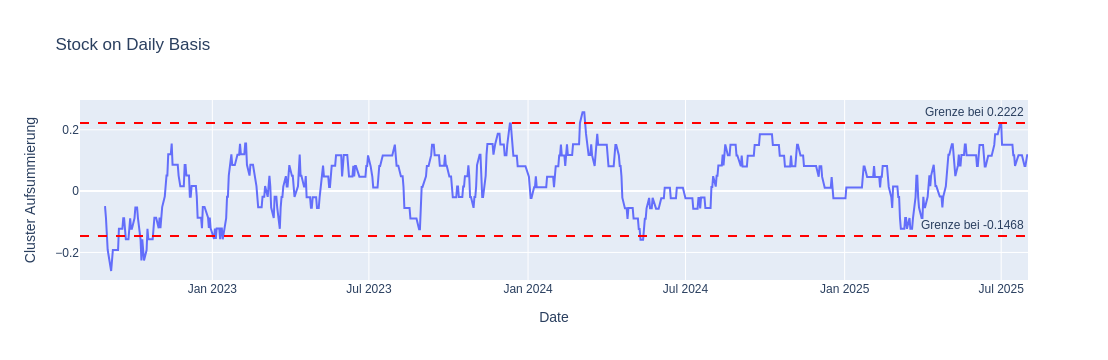

In [10]:
# Calculate the density
describe_ser = df_stock["density"].describe()
upper_limit = describe_ser["mean"] + (describe_ser["std"] * 2)
lower_limit = describe_ser["mean"] - (describe_ser["std"] * 2)
print(describe_ser)

# Show the density
fig = px.line(df_stock, x="date", y="density", title="Stock on Daily Basis",
                  labels={"date": "Date", "density": "Cluster Aufsummierung"})

fig.add_hline(y=upper_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(upper_limit,4)}")
fig.add_hline(y=lower_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(lower_limit,4)}")


fig.show()

### Checking the volatility in percentage daily changes

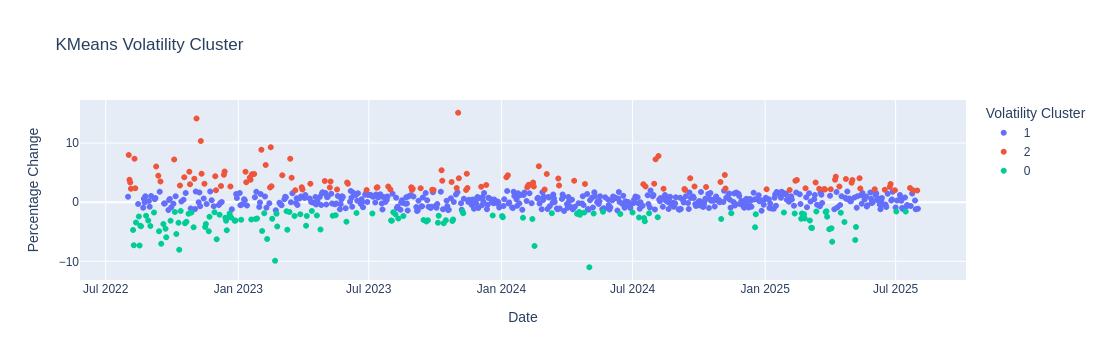

In [11]:
fig = px.scatter(df_stock, x="date", y="perc_change", color="cluster_str", 
                 title="KMeans Volatility Cluster", 
                 labels={"date": "Date", "perc_change": "Percentage Change", 
                         "cluster_str": "Volatility Cluster",})
fig.show()

In [17]:
# Need it for the sell order
df_stock.loc[df_stock['cluster'] == 2]['perc_change'].describe()


count    167.000000
mean      -2.631701
std        1.652373
min      -11.005844
25%       -3.149599
50%       -2.060816
75%       -1.471369
max       -1.091940
Name: perc_change, dtype: float64

### Color the price history according to the column density

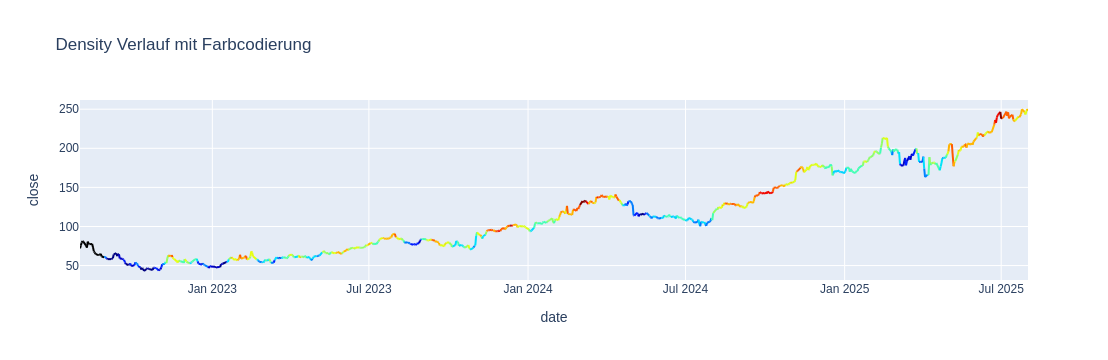

Untere Grenze (vmin): -0.15
Obere Grenze (vmax): 0.22
Mittelwert: 0.04


In [12]:
# Statistical limits for clipping
vmin = lower_limit
vmax = upper_limit

# Create normalization
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

# Create plotly-figure
fig = go.Figure()

# Draw line segments with colors based on density
for i in range(len(df_stock) - 1):
    density_value = df_stock["density"].iloc[i]
    color = get_color(density_value, norm)
    
    fig.add_trace(go.Scatter(
        x=df_stock["date"].iloc[i:i+2],  # Zwei Punkte verbinden
        y=df_stock["close"].iloc[i:i+2],
        mode="lines",
        line=dict(color=color, width=2),
        showlegend=False,
    ))

# Adjust layout
fig.update_layout(
    title="Density Verlauf mit Farbcodierung",
    xaxis_title="date",
    yaxis_title="close",
    # Add colorbar
    coloraxis=dict(
        colorbar=dict(
            title="Density",
            ticktext=["Niedrig (Blau)", "Neutral (Grün)", "Hoch (Rot)"],
            tickvals=[vmin, (vmin+vmax)/2, vmax]
        ),
        colorscale="jet",
        cmin=vmin,
        cmax=vmax
    )
)

fig.show()

# Optional: Ausgabe der Grenzwerte zur Kontrolle
print(f"Untere Grenze (vmin): {vmin:.2f}")
print(f"Obere Grenze (vmax): {vmax:.2f}")
print(f"Mittelwert: {describe_ser['mean']:.2f}")